## Mode sources and mode monitors

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/Modal_sources_monitors.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/Modal_sources_monitors.ipynb), or just follow along with the output below.

Here, we look at a simple demonstration of how to excite a specific waveguide mode, and how to decompose the fields recorded in a monitor on the basis of waveguide modes, i.e. how to compute the power carried in each mode.

In [1]:
# basic ipython configuration (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib as mpl

# get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# tidy3D import
import tidy3d as td
from tidy3d import web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Straight waveguide simulation

First, we will do a simulation of a straight waveguide, using a silicon ridge waveguide on a silicon oxide substrate. We begin by defining some general parameters.

In [2]:
# Unit length is micron.
wg_height = 0.22
wg_width = 0.45

# Permittivity of waveguide and substrate
si_eps = 3.48**2
sio_eps = 1.45**2

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
fwidth = freq0/10

# Simulation size inside the PML along propagation direction
sim_length = 5
resolution = 32

# PML layers
Npml = 15

# Simulation domain size and total run time
sim_size = [sim_length, 4, 2]
run_time = 20/fwidth

### Initialize structures, mode source, and mode monitor

When initializing `ModeSource` and `ModeMonitor` objects, one of the three values of the `size` parameter must be zero. This implicitly defines the propagation direction for the mode decomposition. In this example, the waveguide is oriented along the x-axis, and the mode is injected along the positive-x direction ("forward"). Below, we add a mode monitor that will show us the waveguide transmission at a range of frequencies, as well as a simple frequency monitor to examine the fields in the xy-plane at the central frequency.

In [3]:
# Waveguide and substrate materials
mat_wg = td.Medium(epsilon=si_eps)
mat_sub = td.Medium(epsilon=sio_eps)

# Substrate
substrate = td.Box(
    center=[0, 0, -sim_size[2]],
    size=[td.inf, td.inf, 2*sim_size[2]],
    material=mat_sub)

# Waveguide
waveguide = td.Box(
    center=[0, 0, wg_height/2],
    size=[100, wg_width, wg_height],
    material=mat_wg)

# Modal source
src_pos = -sim_size[0]/2 + 0.5
msource = td.ModeSource(
    center=[src_pos, 0, 0],
    size=[0, 3, 2],
    source_time = td.GaussianPulse(
        frequency=freq0,
        fwidth=fwidth),
    direction='forward')

# xy-plane frequency-domain field monitor at central frequency
freq_mnt = td.FreqMonitor(
    center=[0, 0, wg_height/2],
    size=[100, 100, 0],
    freqs=[freq0])

# Modal monitor at a range of frequencies
Nfreqs = 21
freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, Nfreqs)
fcent_ind = Nfreqs // 2 # index of the central frequency
mode_mnt = td.ModeMonitor(
    center=[-src_pos, 0, 0],
    size=[0, 3, 2],
    freqs=freqs)

Initialize simulation and visualize two cross-sections to make sure we have set up the device correctly.

Initializing simulation...
Mesh step (micron): [3.12e-02, 3.12e-02, 3.12e-02].
Simulation domain in number of grid points: [190, 158, 94].
Total number of grid points: 2.82e+06.
Total number of time steps: 19092.
Estimated data size (GB) of monitor monitor_0: 0.0010.
Estimated data size (GB) of monitor monitor_1: 0.0064.


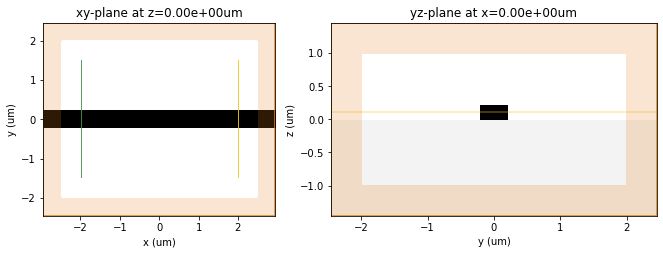

In [4]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    resolution=resolution, 
    structures=[waveguide, substrate], 
    sources=[msource], 
    monitors=[freq_mnt, mode_mnt],
    run_time=run_time,
    pml_layers=[Npml]*3)

fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1.4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.viz_eps_2D(normal='z', ax=ax1, monitor_alpha=0.9, source_alpha=0.9);
sim.viz_eps_2D(normal='x', ax=ax2);

### Mode source

Before we can run a simulation with a mode source, we have to select which of the eigenmodes we would like to inject. To do that, we can first visualize the modes using the in-built eigenmode solver and plotting functions. The modes are computed at the central frequency of the source, and in order of decreasing effective index `n`, such that the modes that are fully below light-line (if any) should appear first. The solver assumes periodic boundary conditions at the boundaries of the 2D plane. Thus, for accurate results, the plane should be large enough for the fields do decay at the edges.

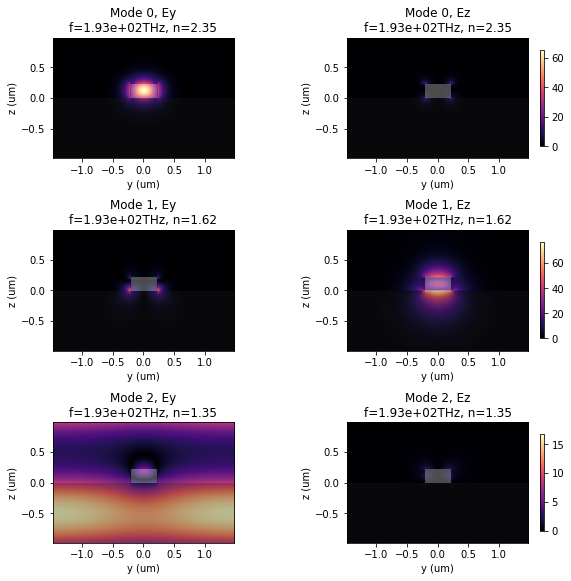

In [5]:
# Visualize waveguide modes
sim.compute_modes(msource, Nmodes=3)
sim.viz_modes(msource, mode_inds=np.arange(3), cbar=True)
plt.show()

The waveguide has a single guided TE mode, as well as a TM mode which is very close to the light line (effective index close to substrate index). Finally, the last mode shown here, Mode 2, is below the light-line of the substrate and is mostly localized in that region. However, modes like these should always be considered unphysical, because of the periodic boundary conditions at the edges that are used in the mode solver. Thus, for meaningful results, only Mode 0 and Mode 1 should be used by the mode source.

### Run simulation

We set the mode source to the fundamental TE mode. Then, we run the simulation as usual through the web API, wait for it to finish, and download and load the results.

In [6]:
sim.set_mode(msource, mode_ind=0)
project = web.new_project(sim.export(), task_name='Waveguide')
web.monitor_project(project['taskId'])

Uploading the json file...
Project "Waveguide-28" status: success...        



In [7]:
web.monitor_project(project['taskId'])

Project "Waveguide-28" status: success...    



In [8]:
web.download_results(project['taskId'], target_folder='out/')
# Show the output of the log file
!cat out/tidy3d.log

Simulation domain Nx, Ny, Nz: 190, 158, 94.
Total number of computational grid points: 2.82e+06.
Total number of time steps: 19092.
Starting Tidy3D... 

Setup time (s): 6.1509
- Time step    954  (  5 % done), field decay: 1.00e+00
- Time step   1909  ( 10 % done), field decay: 9.79e-01
- Time step   2863  ( 15 % done), field decay: 1.23e-04
- Time step   3818  ( 20 % done), field decay: 1.57e-06
- Time step   4772  ( 25 % done), field decay: 1.54e-06
- Time step   5727  ( 30 % done), field decay: 1.55e-06
- Time step   6682  ( 35 % done), field decay: 1.55e-06
- Time step   7636  ( 40 % done), field decay: 1.55e-06
- Time step   8591  ( 45 % done), field decay: 1.55e-06
- Time step   9545  ( 50 % done), field decay: 1.55e-06
- Time step  10500  ( 55 % done), field decay: 1.55e-06
- Time step  11455  ( 60 % done), field decay: 1.55e-06
- Time step  12409  ( 65 % done), field decay: 1.55e-06
- Time step  13364  ( 70 % done), field decay: 1.55e-06
- Time step  14318  ( 75 % done), field 

Let's first examine the in-plane fields recorded by the frequency monitor. We can already see how the source emits all of its power in the desired direction and waveguide mode.

Applying source normalization to all frequency monitors using source index 0.


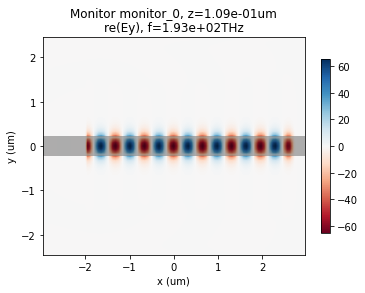

In [9]:
sim.load_results('out/monitor_data.hdf5')
fig, ax = plt.subplots(1, figsize=(6, 4))
sim.viz_field_2D(freq_mnt, ax=ax, cbar=True, comp='y', val='re');

### Mode monitors

Mode monitors allow us to decompose the frequency-domain fields recorded in a simulation into the propagating modes of a waveguide. Specifically, we can write the modes of the waveguide at angular frequency $\omega$ that are propagating in the *forward* direction, i.e. in the positive `x` direction in the example above, as

$$
\mathbf{E}_p^f(\omega, x) = \mathbf{E}_p^f(\omega) e^{i k_p x}, \quad \quad \mathbf{H}_p^f(\omega, x) = \mathbf{H}_p^f(\omega) e^{i k_p x},
$$

where $p$ is a discrete mode index, $k_p = n_p \omega/c$ is the wave-vector, $n_p$ is the effective index of the $p$-th mode, and superscript $f$ specifies forward propagation. The fields in the backward direction can be obtained, in the axes of the simulation, as $k_p \rightarrow -k_p$ and $\mathbf{E}_{p}^b(\omega) = (-E_{p,x}^{f*}, E_{p,y}^{f*}, E_{p,z}^{f*})$, $\mathbf{H}_{p}^b(\omega) = (H_{p,x}^{f*}, -H_{p,y}^{f*}, -H_{p,z}^{f*})$, with $*$ denoting the complex conjugate.

The fields stored in a monitor can then be decomposed on the basis of these waveguide modes. Following [1](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.66.066608), [2](https://arxiv.org/abs/1301.5366), we can define an inner product between fields in the 2D plane as

$$
(\mathbf{u}_1, \mathbf{u}_2) = \frac{1}{4} \int_A \left(\mathbf{E}_1^* \times \mathbf{H}_2 + \mathbf{E}_2 \times \mathbf{H}_1^* \right) \cdot \mathrm{d}\mathbf{A},
$$

where $\mathbf{u} = (\mathbf{E}, \mathbf{H})$ combines both electromagnetic fields, the integration is over the plane area $A$, and $\mathrm{d}\mathbf{A}$ is the surface normal. If a waveguide mode is normalized such that $(\mathbf{u}_p, \mathbf{u}_p) = 1$, and we denote the fields stored in the mode monitor by $\mathbf{u}_s$, then the power amplitude carried by mode $p$ is given by the complex coefficient

$$
c_p = (\mathbf{u}_p, \mathbf{u}_s),
$$

while the power is given by $|c_p|^2$.

In ``Tidy3D``, these coefficients can be obtained by first computing a number of modes of a `ModeMonitor` using ``Simulation.compute_modes(mode_monitor, Nmodes)``, just like we did with the mode source above. This method computes ``Nmodes`` at each of the ``Nfreqs`` frequencies of the monitor.

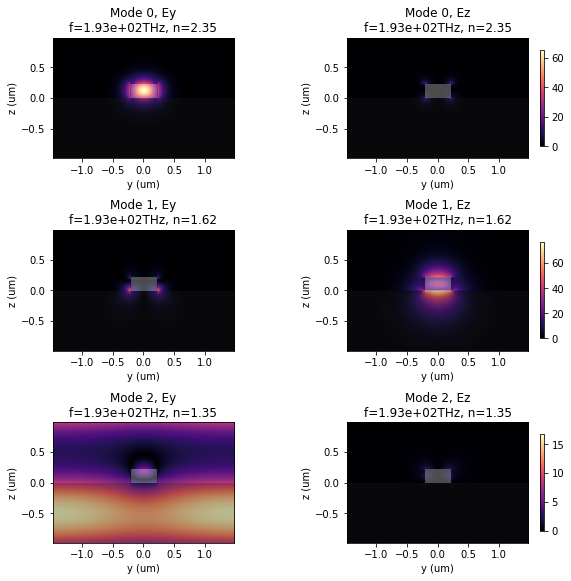

In [10]:
# Compute the monitor modes
sim.compute_modes(mode_mnt, Nmodes=3)
# Visualize the modes at the central frequency
sim.viz_modes(mode_mnt, freq_ind=fcent_ind, mode_inds=np.arange(3), cbar=True)
plt.show()

The modes look exactly as those of the source, since the waveguide cross-section is the same in the two planes. Now, we can use ``Simulation.decompose(mode_monitor)``, which returns a tuple $(c_p^f, c_p^b)$ of the decomposition coefficients into forward- and backward-propagating modes, respectively. More precisely, $c_p^f$ and $c_p^b$ are each arrays of shape ``(Nfreqs, Nmodes)``.

We note that in ``Tidy3D``, the fields recorded by frequency monitors (and thus also mode monitors) are automatically normalized by the power amplitude spectrum of the source (for multiple sources, the user can select which source to use for the normalization). Furthermore, mode sources are normalized to inject exactly 1W of power at the central frequency.

Power distribution at central frequency in first three modes
  positive dir.  [1.0000353e+00 2.6500780e-18 6.6767188e-07]
  negative dir.  [3.1168031e-05 1.8769332e-18 5.8334724e-08]


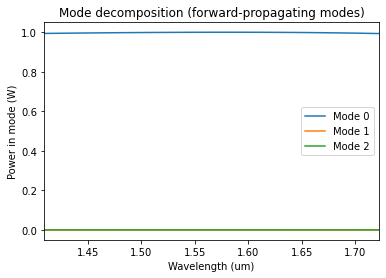

In [11]:
# Forward and backward power amplitude coefficients
coeffs_f, coeffs_b = sim.decompose(mode_mnt)

print("Power distribution at central frequency in first three modes", )
print("  positive dir. ", np.abs(coeffs_f[fcent_ind, :])**2)
print("  negative dir. ", np.abs(coeffs_b[fcent_ind, :])**2)

# Free-space wavelength corresponding to the monitor frequencies
lambdas = mode_mnt.lambdas

fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(lambdas, np.abs(coeffs_f)**2)
ax.set_xlim([lambdas[-1], lambdas[0]])
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Power in mode (W)")
ax.set_title("Mode decomposition (forward-propagating modes)")
ax.legend(["Mode 0", "Mode 1", "Mode 2"])
plt.show()

As we would expect, all of the power is injected into the fundamental waveguide mode, in the forward direction. More precisely, this is true up to some numerical precision that decreases with increasing simulation resolution. We can examine the frequency dependence of the results a bit more closely, and compare them to the total power flux, which can be computed for any frequency monitor. The flux is the area-integrated time-averaged Poynting vector and gives the (signed) total power flowing through the surface.

In [12]:
# Flux in the mode monitor (total power through the cross-section)
flux_wg = sim.flux(mode_mnt)
print("Flux at central frequency: ", flux_wg[fcent_ind])

Flux at central frequency:  [1.00000414]


The flux computation and the modal decomposition are done in a completely different way, but because all the power is in the fundamental mode here, the flux matches really well the zero-mode power from the power decomposition. Finally, let's also compare these two in the full frequency range.

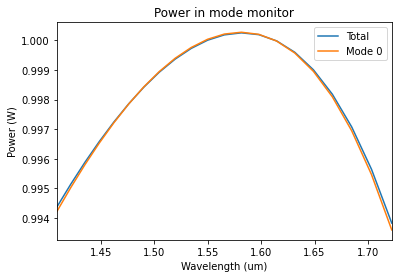

In [13]:
fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(lambdas, flux_wg)
ax.plot(lambdas, np.abs(coeffs_f[:, 0])**2)
ax.set_xlim([lambdas[-1], lambdas[0]])
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Power (W)")
ax.set_title("Power in mode monitor")
ax.legend(["Total", "Mode 0"])

plt.show()

As we already saw, at the central frequency, the source power is extremely well directed in the waveguide mode. Since the source mode is computed at the central frequency only, away from that it is not perfectly matched, leading to a small decrease of the total radiated power. However, all the radiated power is still emitted into the desired waveguide mode, especially within the typical range of interest $1.5\mu m < \lambda < 1.6 \mu m$. For best accuracy when computing scattering parameters away from the central frequency, we then just need to do a "normalization" run like this one to account for the small frequency dependence of the total radiated power.

### Waveguide junction

Finally, we repeat the simulation, but this time introduce a much bigger waveguide in the second half of the domain.

In [14]:
# Output waveguide
wgout_width = 1.4

waveguide_out = td.Box(
    center=[2, 0, wg_height/2],
    size=[4, wgout_width, wg_height],
    material=mat_wg)

Initializing simulation...
Mesh step (micron): [3.12e-02, 3.12e-02, 3.12e-02].
Simulation domain in number of grid points: [190, 158, 94].
Total number of grid points: 2.82e+06.
Total number of time steps: 19092.
Estimated data size (GB) of monitor monitor_0: 0.0010.
Estimated data size (GB) of monitor monitor_1: 0.0064.


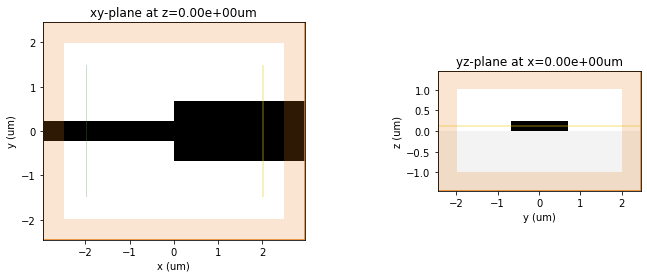

In [15]:
sim = td.Simulation(size=sim_size,
                    resolution=resolution, 
                    structures=[waveguide, waveguide_out, substrate], 
                    sources=[msource], 
                    monitors=[freq_mnt, mode_mnt],
                    run_time=run_time,
                    pml_layers=[Npml]*3)

fig = plt.figure(figsize=(12, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim.viz_eps_2D(normal='z', ax=ax1);
sim.viz_eps_2D(normal='x', ax=ax2);

We set the same mode source in the original waveguide, but we need to recompute the modes at the monitor location.

In [16]:
sim.set_mode(msource, 0)
project = web.new_project(sim.export(), task_name='Waveguide')
web.monitor_project(project['taskId'])
web.download_results(project['taskId'], target_folder='out/')
sim.load_results('out/monitor_data.hdf5')

Selected mode index larger than number of stored modes. Recomputing eigenmodes modes up to mode index.
Uploading the json file...
Project "Waveguide-29" status: success...       

Applying source normalization to all frequency monitors using source index 0.


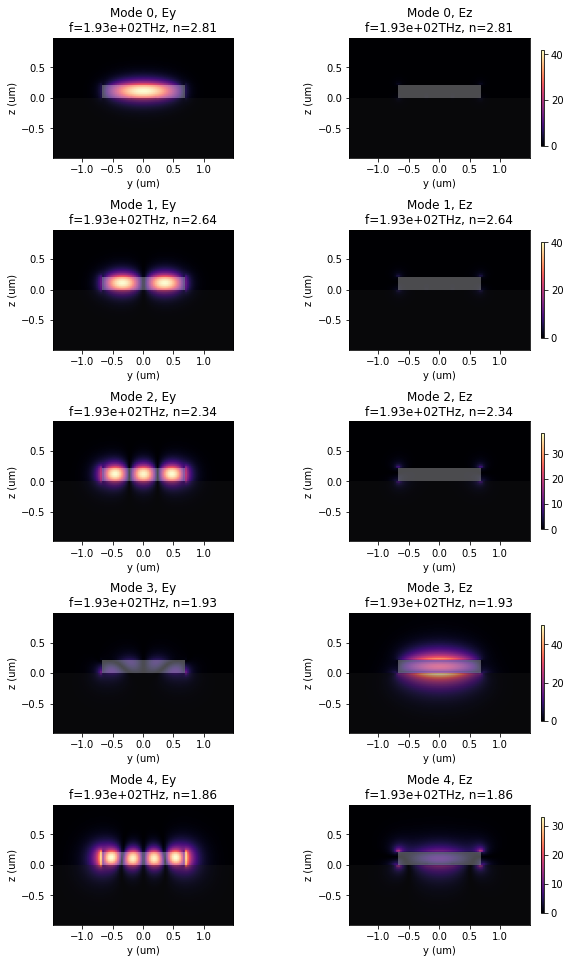

In [17]:
num_modes = 5
# Compute the monitor modes
sim.compute_modes(mode_mnt, Nmodes=num_modes)
# Visualize the modes at the central frequency
sim.viz_modes(mode_mnt, freq_ind=fcent_ind, mode_inds=np.arange(num_modes), cbar=True)
plt.show()

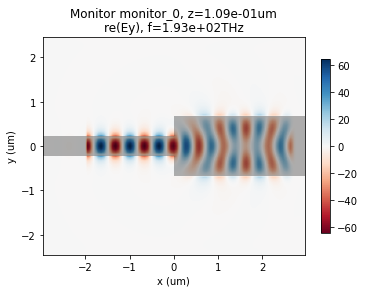

In [18]:
# Show in-plane propagation
fig, ax = plt.subplots(1, figsize=(6, 4))
sim.viz_field_2D(freq_mnt, ax=ax, cbar=True, comp='y', val='re');

This time, the output waveguide is multi-mode, and there is obviously some mode-mixing happening. We can use the mode monitor to exactly quantify this.

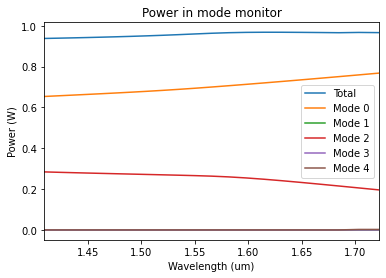

In [19]:
# Compute decomposition coefficients
coeffs_out_f, coeffs_out_b = sim.decompose(mode_mnt)
# Normalize by the flux recorded in the normalization run
coeffs_out_f /= flux_wg
coeffs_out_b /= flux_wg

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(lambdas, np.sum(np.abs(coeffs_out_f)**2, axis=1))
ax.plot(lambdas, np.abs(coeffs_out_f)**2)
ax.set_xlim([lambdas[-1], lambdas[0]])
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Power (W)")
ax.set_title("Power in mode monitor")
ax.legend(["Total"] + ["Mode %d"%i for i in range(num_modes)])

plt.show()

Because of the symmetry with respect to the $y=0$ plane, the power in Mode 0 cannot be converted to Mode 1, but a significant amount of power is converted to Mode 3. Note also that the combined power in the computed modes is smaller than 1W. The missing part is most likely lost in scattering at the sharp waveguide interface.